### Otimização dos Dados

- Continuando a etapa anterior, agora vamos avaliar os erros cometidos pelos modelos, buscando insights que nos guiem para alterar ou complementar os dados.

- Para avaliar os erros, vamos utilizar, primeiramente, a **matriz de confusão** da classificação.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
def get_data(train_path, test_path):
    train = pd.read_csv(train_path, header=0)
    test = pd.read_csv(test_path, header=0)
    data_train = train.to_numpy()
    n_row, n_col = data_train.shape
    X = data_train[:, 1:n_col]
    y = data_train[:,0]
    X_test = test.to_numpy()
    return X, y, X_test

def get_scale(train, test):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_test = scaler.transform(X_test) 
    return X, X_test

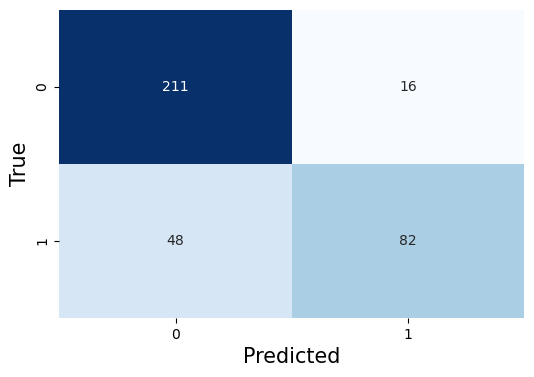

In [80]:
from sklearn.ensemble import RandomForestClassifier

X, y, X_test = get_data("dados/treino_tratado_2.csv", "dados/teste_tratado_2.csv")
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=5)

rf = RandomForestClassifier(max_depth=9, min_samples_leaf=15, min_samples_split=20, random_state=42)

model_rf = rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_valid)

cm = confusion_matrix(y_true=y_valid, y_pred=y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("True", fontsize=15)
plt.show()

In [9]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.97      0.85       209
         1.0       0.93      0.54      0.68       148

    accuracy                           0.79       357
   macro avg       0.84      0.76      0.76       357
weighted avg       0.82      0.79      0.78       357



- Notamos que o modelo está classificando muitos indivíduos que sobreviveram como óbitos, ou seja, há uma grande taxa de **Falsos Negativos**;

- **Hipóteses**: 

    - A primeira hipótese da causa desse fato é que o conjunto de dados esteja mais **desbalanceado** que o previsto no ínicio;
    - Outra hipótese seria que o modelo não esteja distinguindo corretamente a respeito da sobrevivência de homens ricos, dado que a maioria dos homens morreram;
    - A classificação da classe financeira dos passageiros pode estar errônea:
        - Ocorre que os portos de embarque eram distantes uns dos outros, ou seja, o passageiro que embarcou no porto mais longe pagou mais caro que o passageiro do porto mais próximo da chegada, independente da classe financeira.

- Para comprovar as hipótese, vamos realizar uma análise exploratória nos dados Falsos Negativos.

In [81]:
Y_true = pd.DataFrame()
Y_pred = pd.DataFrame()

Y_true["True"] = y_valid
Y_pred["Predict"] = y_pred

Y_true = Y_true[Y_true["True"] == 1]
Y_pred = Y_pred[Y_pred["Predict"] == 0]

index_falneg = Y_true.index.intersection(Y_pred.index)
X_falneg = X_valid[index_falneg]


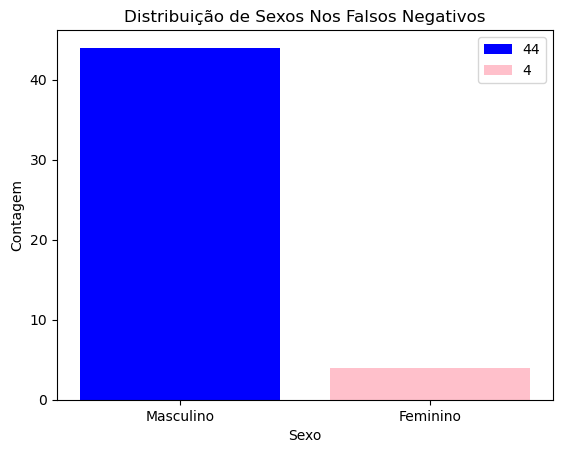

In [82]:
sex_data = X_falneg[:,4]

unique_sex, counts = np.unique(sex_data, return_counts=True)

plt.bar(unique_sex, counts, color=['blue', 'pink'], label=counts ) 
plt.xlabel('Sexo')
plt.ylabel('Contagem')
plt.title('Distribuição de Sexos Nos Falsos Negativos')
plt.xticks(unique_sex, ['Masculino', 'Feminino']) 
plt.legend()
plt.show()

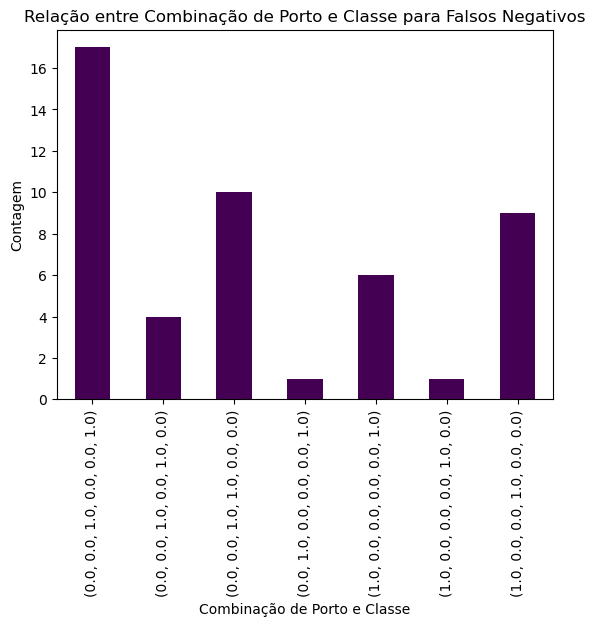

In [83]:

data = {'Porto_S': X_falneg[:, 6], 'Porto_C': X_falneg[:, 7], 'Porto_Q': X_falneg[:, 8], 'Classe_1': X_falneg[:, 9], 
        'Classe_2': X_falneg[:, 10], 'Classe_3': X_falneg[:, 11]}
df = pd.DataFrame(data) 

counts = df.groupby(['Porto_S', 'Porto_C', 'Porto_Q', 'Classe_1', "Classe_2", 'Classe_3']).size()
ax = counts.plot(kind='bar', stacked=True, colormap='viridis')

# Adicionar rótulos ao gráfico
plt.xlabel('Combinação de Porto e Classe')
plt.ylabel('Contagem')
plt.title('Relação entre Combinação de Porto e Classe para Falsos Negativos')

# Mostrar o gráfico
plt.show()


- Após diversos testes de *Seeds* de divisões dos conjuntos, vemos que as estatísticas se mantém, desse modo, observamos que a grande maioria dos erros são referentes a homens, mas ao contrário do que imaginávamos, os homens em questão, embarcaram no último porto e a maioria na terceira classe, ou seja, pagaram os menores valores de **Fare**, com isso, concluímos que a maior dificuldade do modelo está em prever a sobrevivência dos homens mais pobres.

- Agora, passamos a procurar motivos para esses homens terem sobrevivido, afim de tornar possível a classificação dos mesmos.

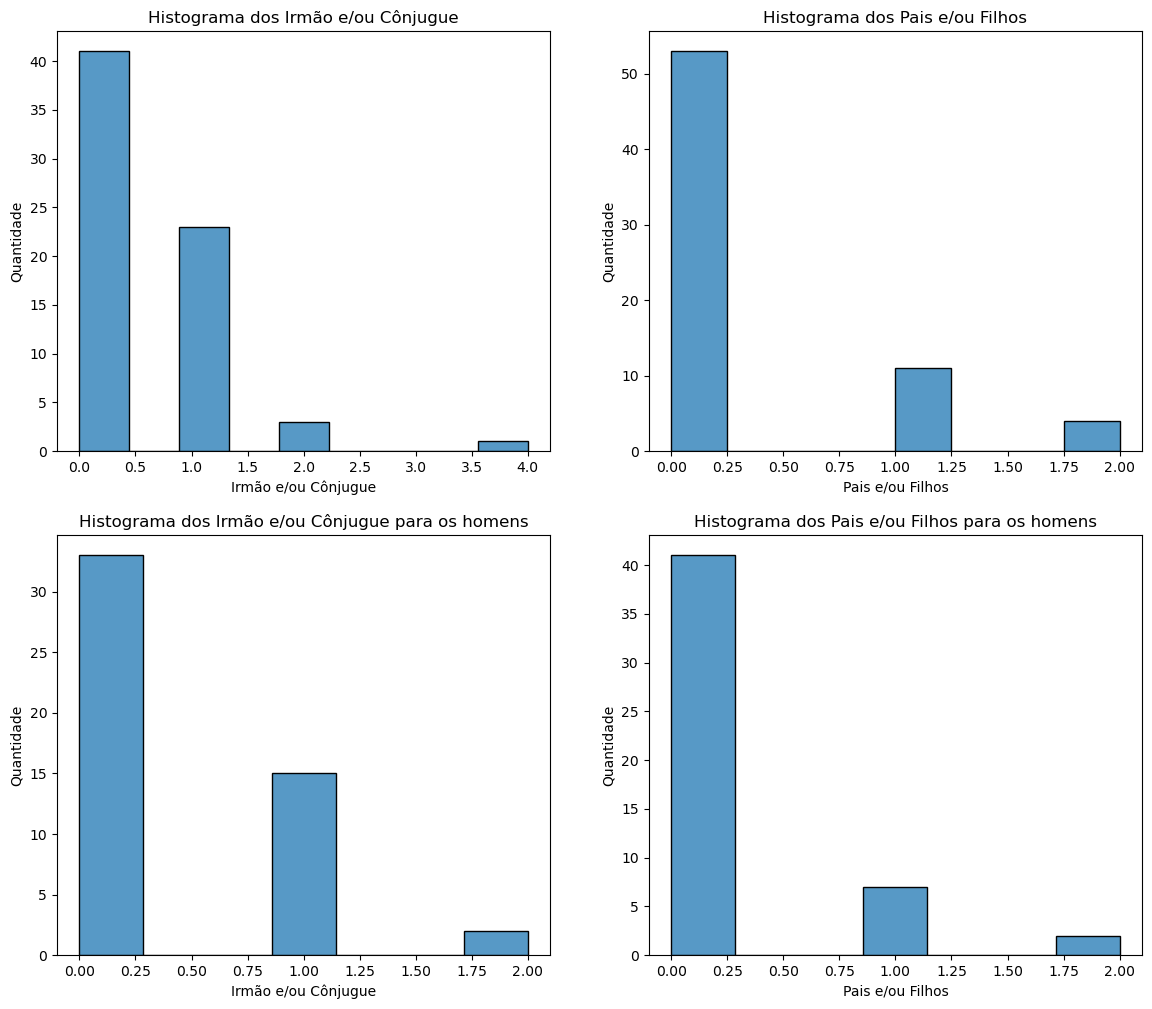

In [75]:
mask = X_falneg[:, 5] == 1
X_falneg_man = X_falneg[mask]

figure, ax = plt.subplots(2, 2, figsize=(14,12))

sns.histplot(X_falneg[:,1], bins='auto',ax=ax[0,0])
ax[0,0].set_title("Histograma dos Irmão e/ou Cônjugue")
ax[0,0].set_xlabel("Irmão e/ou Cônjugue")
ax[0,0].set_ylabel("Quantidade")

sns.histplot(X_falneg[:,2], bins='auto',ax=ax[0,1])
ax[0,1].set_title("Histograma dos Pais e/ou Filhos")
ax[0,1].set_xlabel("Pais e/ou Filhos")
ax[0,1].set_ylabel("Quantidade")

sns.histplot(X_falneg_man[:,1], bins='auto',ax=ax[1,0])
ax[1,0].set_title("Histograma dos Irmão e/ou Cônjugue para os homens")
ax[1,0].set_xlabel("Irmão e/ou Cônjugue")
ax[1,0].set_ylabel("Quantidade")

sns.histplot(X_falneg_man[:,2], bins='auto',ax=ax[1,1])
ax[1,1].set_title("Histograma dos Pais e/ou Filhos para os homens")
ax[1,1].set_xlabel("Pais e/ou Filhos")
ax[1,1].set_ylabel("Quantidade")

plt.show()


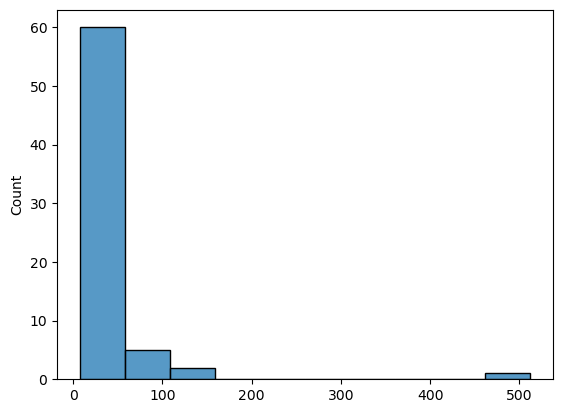

In [79]:
sns.histplot(X_falneg[:,3], bins=10)
plt.show()

- A princípio, o que pode ser feito é utilizar do fato de que os homens ricos tem mais chance de sobreviver e, sendo assim, construir uma *feature* no qual trata de maneira relativa de acordo com cada porto.

- Isso também pode auxiliar a diminuir a classificação de **Falsos Positivos**, caso o modelo, considere que um homem de classe baixa sobreviva.

In [90]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Carregando os dados
df_train = pd.read_csv("dados/treino_tratado_2.csv", header=0)
df_test = pd.read_csv("dados/teste_tratado_2.csv", header=0)

# Calculando os máximos e mínimos preços de cada porto
mask_S = df_train["Harbor_S"] == 1
df_S = df_train[mask_S]
df_S['Fare'] = scaler.fit_transform(df_S['Fare'])
df_S.head()


ValueError: Expected 2D array, got 1D array instead:
array=[  7.25     7.925   53.1      8.05    51.8625  21.075   11.1333  16.7
  26.55     8.05    31.275    7.8542  16.      13.      18.      26.
  13.      35.5     21.075   31.3875 263.       7.8958  10.5     52.
   8.05    18.       9.475   21.       8.05    17.8     39.6875   7.8
  26.      35.5     10.5     27.75    46.9     80.      83.475   27.9
  10.5      8.1583   7.925    8.6625  10.5     46.9     73.5     56.4958
   7.65     7.8958   8.05    29.      12.475    9.       9.5     47.1
  10.5     15.85    34.375    8.05   263.       8.05     8.05     7.8542
  61.175   20.575    7.25     8.05    23.      26.       7.8958   7.8958
  77.2875   8.6542   7.925    7.8958   7.65     7.775    7.8958  52.
   8.05     9.825    7.925   21.      31.275   73.5      8.05    13.
  77.2875   7.1417   6.975    7.05    14.5     26.      13.      26.2833
  53.1      9.2167   7.75    15.85    11.5     36.75     7.7958  34.375
  26.      13.      12.525   66.6      8.05    14.5      7.3125   8.05
   8.6625  69.55    16.1     15.75     7.775    8.6625  39.6875  20.525
  55.      27.9     25.925   56.4958  33.5     11.1333   7.925    7.8542
  25.4667  13.       0.      69.55    31.3875  39.      22.025   50.
  26.55     7.8958  13.      13.       7.8542  26.       8.4042  13.
   9.5     69.55     6.4958   8.05    10.4625  15.85     7.05    21.
   7.25    13.       7.925   27.      10.5      8.05    13.       8.05
   7.8958  90.       9.35    10.5      7.25    13.      25.4667  83.475
   7.775   13.5     31.3875  10.5      7.55    26.      26.25    10.5
  12.275   10.5      7.125    7.775   14.5     52.5542  26.       7.25
  10.4625  26.55    16.1     20.2125  86.5     26.      31.3875  79.65
   0.      10.5     39.6875   7.775  153.4625 135.6333  31.       0.
  19.5     77.9583   7.75     0.      20.25     7.8542   9.5      8.05
  26.       9.5      7.8958  13.      78.85     8.85     7.8958 151.55
  30.5      0.       8.05   151.55    26.       7.8958  26.25     7.8542
  26.      14.     164.8667   7.25     7.8958  29.      69.55     6.2375
  13.      20.525   28.5    153.4625  18.     133.65     7.8958  66.6
   8.05    35.5     26.     263.      13.      13.      13.      13.
  13.      16.1     15.9      8.6625   9.225   35.      17.8      9.5
  55.      13.      27.9      7.05     7.25     6.4958   8.05    21.075
   7.25     7.775    7.925   52.       7.8958  73.5     46.9     13.
 120.       7.7958   7.925   16.7      7.7958   7.8542  26.      10.5
  12.65     7.925    8.05     9.825   15.85     8.6625  21.       7.75
  18.75     7.775   25.4667   7.8958   0.       7.925    8.05    32.5
  13.      13.      24.15     7.875   14.4     20.2125   7.25    26.
  26.       8.05    26.55    16.1     26.       7.125   55.9    120.
  34.375   18.75   263.      10.5     26.25     9.5      7.775   13.
   8.1125  81.8583  19.5     26.55    30.5     27.75    19.9667   8.05
  26.55    51.8625  10.5     26.55     8.05    38.5     13.       8.05
   7.05     0.      26.55     7.25     8.6625  27.75     9.8375  52.
  21.       7.0458   7.5208  12.2875  46.9      0.       8.05     9.5875
  25.4667  90.       8.05    15.9     19.9667   7.25    30.5      8.05
  15.1    151.55     7.7958   8.6625   9.5875  86.5     26.      26.55
  22.525   56.4958   8.05    26.2875   7.4958  34.0208  10.5     26.
   7.8958  93.5      7.8958  10.5    221.7792   7.925   11.5     26.
   8.6625  26.25    26.55    14.5     71.      31.275   31.275   26.
  26.      26.      20.525   36.75    26.       7.775   26.55    79.65
  17.4      7.8958  13.5      8.05     8.05    24.15     7.8958  21.075
   7.8542  10.5     51.4792  26.3875   8.05    14.5     13.      55.9
   7.925   30.      26.      79.65    15.       8.05     8.05     7.125
   7.25    26.      24.15    33.       0.      27.       7.8958  42.4
   8.05    15.55     7.8958  30.5    153.4625  31.275    7.05     8.05
  65.      14.4     16.1     39.      10.5     52.5542   7.8542  16.1
  32.3208  77.9583   7.8958  30.       7.0542   0.      27.9     13.
   7.925   26.25    39.6875  16.1      7.8542  27.9     56.4958   7.8958
   7.55     7.55     7.8958  23.       8.4333  73.5      7.8958  13.
 133.65    25.5875   7.4958   7.925   73.5     13.       7.775    8.05
  52.      39.      52.      10.5     13.       0.       7.775    8.05
   9.8417  46.9      9.225   46.9     39.      39.6875  10.1708   7.7958
 211.3375  57.      56.4958  26.55    13.5      8.05     7.65    26.2875
   7.8542  26.      13.5     26.2875 151.55    26.55    52.       9.4833
  13.       7.65    10.5      7.775   33.       7.0542  13.      13.
  53.1      8.6625  21.      26.       7.925  211.3375   0.      13.
  13.      16.1     34.375    7.8958   7.8958  30.      78.85    16.1
   7.925   71.      20.25    13.      53.1     23.      12.475    9.5
   7.8958  65.      14.5      7.7958  11.5      8.05    86.5     14.5
   7.125  120.       7.775   77.9583   8.3625   9.5      7.8542  10.5
  23.       7.75    12.475  211.3375  57.      30.      23.45     7.05
   7.25     7.4958  20.575   26.      69.55     7.8958  13.      25.9292
   8.6833  24.15    13.      26.25   120.       6.975    7.775    0.
   7.775   13.      53.1      7.8875  24.15    10.5     31.275    8.05
   0.       7.925    6.45    27.9     93.5      8.6625   0.      12.475
  39.6875  56.4958  80.      18.75     7.8542   8.3      8.6625   8.05
  56.4958   7.925   10.5      8.6625   7.55    69.55    33.      31.275
   7.775   39.4     26.       9.35   164.8667  26.55    14.1083  11.5
  25.9292  69.55    13.      13.      50.4958   9.5     11.1333   7.8958
  52.5542   5.       9.       9.8458   7.8958   7.8958  26.       7.8958
  10.5167  10.5      7.05    13.      30.      23.45  ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.